<a href="https://colab.research.google.com/github/PioDru/colab/blob/main/fruit_360_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix ,classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Dense ,Conv2D , MaxPooling2D , Flatten , Activation , Dropout ,Lambda
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint, EarlyStopping

import keras
from keras import ops


In [2]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git


Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165 (from 1)
Receiving objects: 100% (385858/385858), 2.10 GiB | 29.68 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Updating files: 100% (90503/90503), done.


In [3]:
##############################################
learning_rate = 0.1 # initial learning rate
min_learning_rate = 0.00001 # once the learning rate reaches this value , do not decrease it further
learning_rate_reduction_factor = 0.5 # the factor used when reducing the learning rate ->
learning_rate *= learning_rate_reduction_factor
patience = 3 # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1 # controls the amount of logging done during training and testing: 0 - none , 1 - reports metrics after each batch , 2 - reports metrics after each epoch
image_size = (100, 100) # width and height of the used images
input_shape = (100, 100, 3) # the expected input shape for the trained models; since the images in the Fruit -360 are 100 x 100 RGB images , this is the required input shape

use_label_file = False # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels , each label on a separate line
label_file = 'labels.txt'
#base_dir = '../..' # relative path to the Fruit - Images - Dataset folder
base_dir = '/content/Fruit-Images-Dataset' # relative path to the Fruit - Images - Dataset folder

test_dir = os.path.join(base_dir , 'Test')
train_dir = os.path.join(base_dir , 'Training')
output_dir = 'output_files' # root folder in which to save the the output files; the files will be under output_files/model_name
##############################################

In [4]:
keras.saving.get_custom_objects().clear()

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# if we want to train the network for a subset of the fruit classes instead of all, we can set the use_label_file to true and place in the label_file the classes we want to train for, one per line
if use_label_file:
    with open(label_file , "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
num_classes = len(labels)


# create 2 charts , one for accuracy , one for loss , to show the evolution of these two metrics during the training process
def plot_model_history(model_history , out_path=""):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['acc']) + 1), model_history.history['acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1, len(model_history.history['acc']) + 1), len(model_history.history['acc']))
    #axs[0].set_xticks(np.arange(1, len(model_history.history['acc']) + 1), len(model_history.history['acc']))
    axs[0].legend(['train'], loc='best')
    # summarize history for loss

    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    #axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    axs[1].legend(['train'], loc='best')
    # save the graph in a file called "acc.png" to be available for later; the model_name is provided when creating and training a model
    if out_path:
        plt.savefig(out_path + "/acc.png")
    plt.show()


# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true , y_pred , classes ,out_path=""):
    cm = confusion_matrix(y_true , y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm , annot=True , square=True ,fmt="d", linewidths=.2, cbar_kws={"shrink":0.8})
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png") # as in the plot_model_history , the matrix is saved in a file called "model_name_confusion_matrix.png"
    return ax


# Randomly changes hue and saturation of the image to simulate variable lighting conditions

def augment_image(x):
    x = tf.image.random_saturation(x, 0.9, 1.2)
    x = tf.image.random_hue(x, 0.02)
    return x


# given the train and test folder paths and a validation to test ratio , this method creates three generators
# - the training generator uses (100 - validation_percent) of images from the train set
# it applies random horizontal and vertical flips for data augmentation and generates batches randomly
# - the validation generator uses the remaining validation_percent of images from the train set
# does not generate random batches , as the model is not trained on this data
# the accuracy and loss are monitored using the validation data so that the learning rate can be updated if the model hits a local optimum
# - the test generator uses the test set without any form of augmentation
# once the training process is done , the final values of accuracy and loss are calculated on this set
def build_data_generators(train_folder , test_folder , labels=None , image_size=(100, 100), batch_size=50):
    train_datagen = ImageDataGenerator(width_shift_range=0.0, height_shift_range=0.0, zoom_range=0.0, horizontal_flip=True ,vertical_flip=True , preprocessing_function=augment_image) # augmentation is done only on the train set (and optionally validation)

    test_datagen = ImageDataGenerator()

    train_gen = train_datagen.flow_from_directory(train_folder , target_size=image_size ,class_mode='sparse', batch_size=batch_size ,shuffle=True , subset='training', classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder , target_size=image_size , class_mode='sparse', batch_size=batch_size , shuffle=False , subset=None , classes=labels)
    return train_gen , test_gen


# Create a custom layer that converts the original image from # RGB to HSV and grayscale and concatenates the results
# forming in input of size 100 x 100 x 4
@keras.saving.register_keras_serializable(package="my_package", name="convert_to_hsv_and_grayscale")
def convert_to_hsv_and_grayscale(x):
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez


def network(input_shape , num_classes):
    img_input = Input(shape=input_shape , name='data')
    x = Lambda(convert_to_hsv_and_grayscale)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes , activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input , outputs=out)
    return rez

# this method performs all the steps from data setup , training and testing the model and plotting the results
# the model is any trainable model; the input shape and output number of classes is dependant on the dataset used , in this case the input is 100x100 RGB images and the output is a softmax layer with 118 probabilities
# the name is used to save the classification report containing the f1 score of the model , the plots showing the loss and accuracy and the confusion matrix
# the batch size is used to determine the number of images passed through the network at once , the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
def train_and_evaluate_model(model , name="", epochs=25, batch_size=50, verbose=verbose , useCkpt=False):
    print(model.summary())
    model_out_dir = os.path.join(output_dir , name)
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
    if useCkpt:
        #model.load_weights(model_out_dir + "/model.h5")
        model.load_weights(model_out_dir + "/model.keras")

    trainGen , testGen = build_data_generators(train_dir , test_dir , labels=labels , image_size=image_size , batch_size=batch_size)
    #optimizer = Adadelta(lr=learning_rate)
    optimizer = Adadelta(learning_rate=learning_rate)
    model.compile(optimizer=optimizer , loss="sparse_categorical_crossentropy", metrics=["acc"])
    learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=patience , verbose=verbose ,factor=learning_rate_reduction_factor,min_lr=min_learning_rate)
    #save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='loss',verbose=verbose ,save_best_only=True ,save_weights_only=False , mode='min',save_freq='epoch')
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.keras", monitor='loss',verbose=verbose ,save_best_only=True ,save_weights_only=False , mode='min',save_freq='epoch')
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=3,          # Number of epochs with no improvement after which training will be stopped
        verbose=1,          # Verbosity mode (0: silent, 1: print messages)
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )
    history = model.fit(trainGen , epochs=epochs , steps_per_epoch=(trainGen.n // batch_size) + 1,verbose=verbose , callbacks=[learning_rate_reduction , save_model])
    #history = model.fit(trainGen , epochs=epochs , steps_per_epoch=(trainGen.n // batch_size) + 1,verbose=verbose , callbacks=[learning_rate_reduction , save_model, early_stopping])

    #model.load_weights(model_out_dir + "/model.h5")
    model.load_weights(model_out_dir + "/model.keras")
    '''
    trainGen.reset()
    loss_t , accuracy_t = model.evaluate(trainGen ,steps=(trainGen.n // batch_size) + 1, verbose=verbose)
    loss , accuracy = model.evaluate(testGen , steps=(testGen.n // batch_size) + 1, verbose=verbose)
    print("Train: accuracy = %f ; loss_v = %f" % (accuracy_t , loss_t))
    print("Test: accuracy = %f ; loss_v = %f" % (accuracy , loss))
    plot_model_history(history , out_path=model_out_dir)
    testGen.reset()
    '''
    y_pred = model.predict(testGen , steps=(testGen.n// batch_size) + 1, verbose=verbose)
    '''
    y_true = testGen.classes[testGen.index_array]
    plot_confusion_matrix(y_true , y_pred.argmax(axis=-1), labels , out_path=model_out_dir)
    class_report = classification_report(y_true ,y_pred.argmax(axis=-1), target_names=labels)

    with open(model_out_dir + "/classification_report.txt", "w") as text_file:
        text_file.write("%s" % class_report)
    '''

print(labels)
print(num_classes)
model = network(input_shape=input_shape , num_classes=num_classes)
train_and_evaluate_model(model , name="fruit-360_model")
#train_and_evaluate_model(model , name="fruit-360_model", useCkpt=True)
#train_and_evaluate_model(model , name="fruit-360_model", epochs=10)


['Lemon Meyer', 'Peach 2', 'Tomato not Ripened', 'Apricot', 'Apple Red Delicious', 'Pitahaya Red', 'Dates', 'Mulberry', 'Tomato Maroon', 'Pear Stone', 'Cherry Rainier', 'Potato Sweet', 'Walnut', 'Blueberry', 'Corn', 'Orange', 'Corn Husk', 'Avocado', 'Lemon', 'Lychee', 'Nectarine Flat', 'Pear 2', 'Grape White 3', 'Kohlrabi', 'Apple Granny Smith', 'Pepper Red', 'Mango Red', 'Beetroot', 'Tomato 3', 'Mangostan', 'Tomato 4', 'Apple Pink Lady', 'Carambula', 'Mango', 'Cherry 1', 'Cauliflower', 'Banana Lady Finger', 'Apple Golden 3', 'Cantaloupe 2', 'Watermelon', 'Banana', 'Cherry Wax Black', 'Redcurrant', 'Chestnut', 'Onion Red', 'Plum 3', 'Plum', 'Pomegranate', 'Peach', 'Tomato Heart', 'Maracuja', 'Physalis with Husk', 'Fig', 'Apple Golden 2', 'Grape Blue', 'Hazelnut', 'Apple Red Yellow 1', 'Melon Piel de Sapo', 'Potato White', 'Apple Golden 1', 'Tomato Cherry Red', 'Cucumber Ripe 2', 'Apple Red 1', 'Apple Crimson Snow', 'Kaki', 'Pear Forelle', 'Physalis', 'Cherry Wax Yellow', 'Grapefruit Pi

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)                    │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 100, 100, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 100, 100, 16)        │           1,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (Activation)              │ (None, 100, 100, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 50, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 50, 50, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_relu (Activation)              │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 25, 25, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_relu (Activation)              │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 12, 12, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_relu (Activation)              │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fcl1 (Dense)                         │ (None, 1024)                │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fcl2 (Dense)                         │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 131)                 │          33,667 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,286,323 (20.17 MB)

 Trainable params: 5,286,323 (20.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1353/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - acc: 0.1213 - loss: 5.2273
Epoch 1: loss improved from inf to 3.30430, saving model to output_files/fruit-360_model/model.keras
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 221s 157ms/step - acc: 0.1216 - loss: 5.2244 - learning_rate: 0.0500
Epoch 2/25

Epoch 2: loss improved from 3.30430 to 0.00000, saving model to output_files/fruit-360_model/model.keras


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1354/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0500
Epoch 3/25
1353/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - acc: 0.6708 - loss: 1.1637
Epoch 3: loss did not improve from 0.00000
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 209s 154ms/step - acc: 0.6709 - loss: 1.1634 - learning_rate: 0.0500
Epoch 4/25

Epoch 4: loss did not improve from 0.00000
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0500
Epoch 5/25
1353/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - acc: 0.8484 - loss: 0.4983
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.

Epoch 5: loss did not improve from 0.00000
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 210s 155ms/step - acc: 0.8484 - loss: 0.4981 - learning_rate: 0.0500
Epoch 6/25

Epoch 6: loss did not improve from 0.00000
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0250
Epoch 7/25
1353/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [5]:
!wget -O banana.jpg https://upload.wikimedia.org/wikipedia/commons/8/8a/Banana-Single.jpg

--2024-12-04 16:49:13--  https://upload.wikimedia.org/wikipedia/commons/8/8a/Banana-Single.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2085213 (2.0M) [image/jpeg]
Saving to: ‘banana.jpg’

banana.jpg          100%[===================>]   1.99M  13.0MB/s    in 0.2s    

2024-12-04 16:49:13 (13.0 MB/s) - ‘banana.jpg’ saved [2085213/2085213]



(100, 100, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Cantaloupe 1


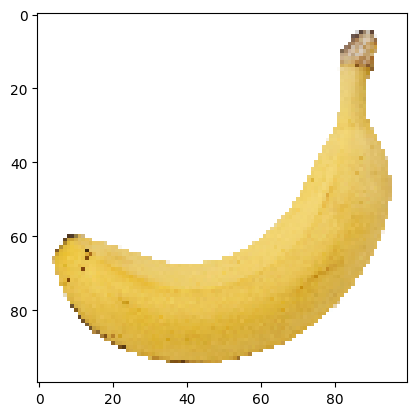

In [6]:
img4 = tf.keras.preprocessing.image.load_img('banana.jpg', target_size=(100, 100))
img4 = tf.keras.preprocessing.image.img_to_array(img4)
plt.imshow(img4.astype(np.int32))
print(img4.shape)

image4 = np.array([img4])

labels[np.argmax(model.predict(image4))]
print(labels[np.argmax(model.predict(image4))])

(100, 100, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Apple Red Delicious


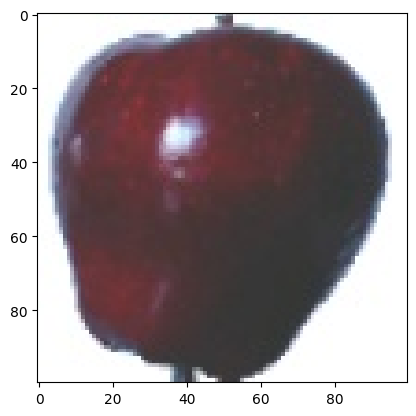

In [7]:
# prediction using picture from the dataset

img2 = tf.keras.preprocessing.image.load_img('/content/Fruit-Images-Dataset/Test/Apple Red Delicious/0_100.jpg', target_size=(100, 100))
img2 = tf.keras.preprocessing.image.img_to_array(img2)
plt.imshow(img2.astype(np.int32))
print(img2.shape)

image2 = np.array([img2])

labels[np.argmax(model.predict(image2))]
print(labels[np.argmax(model.predict(image2))])